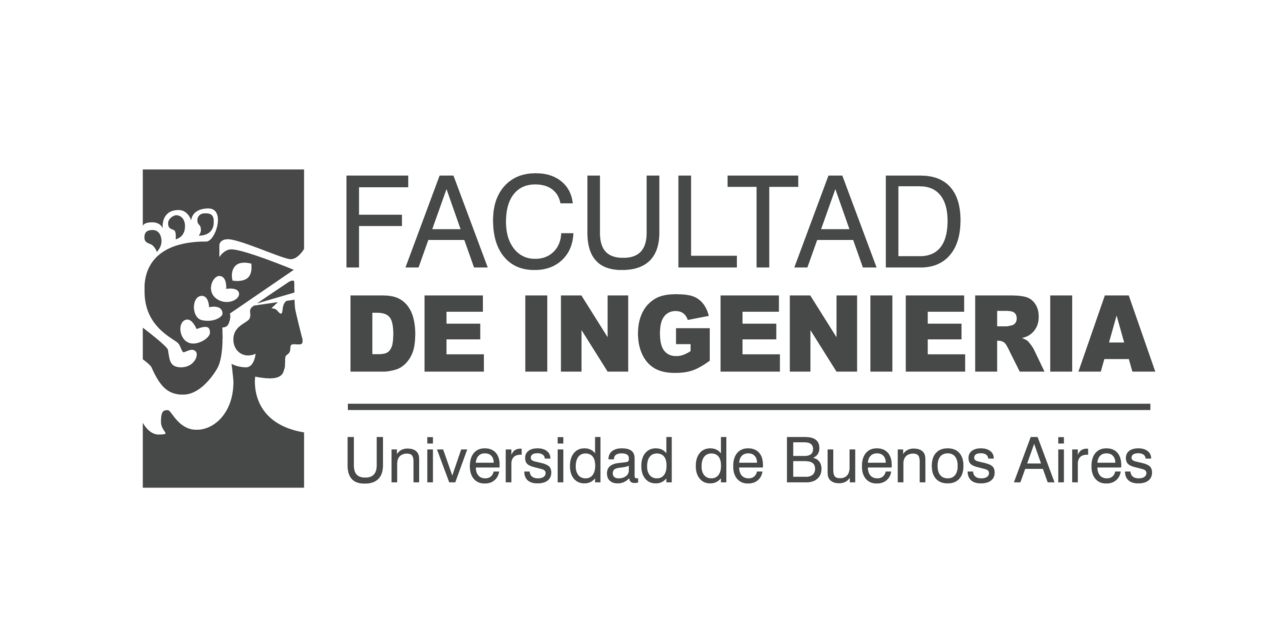

## Aprendizaje Profundo - TP2
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna: **Clasificador de Emociones**

Este segundo TP comienza desde el día después de la clase 5 (2 de abril) y la ventana de entrega estará abierta hasta las **23hs del miércoles 23 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/XatA691so4eVxZB68)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/10EWwOriegjawQ3evl1nuIldY3pUR-hQc/view?usp=sharing

## Prerequisitos y dependencias

In [ ]:
%pip install gdown
%pip install pandas
%pip install numpy
%pip install torch
%pip install torchinfo
%pip install torchvision
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn

In [20]:
import os
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torchinfo as torchinfo
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import random_split
from collections import defaultdict, Counter
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset


# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# PARAMETROS GLOBALES
BATCH_SIZE = 128
WORKERS = 4
DATASET_AUGMENTED_SIZE = 30000

In [3]:
# Descarga dataset
!gdown --id 10EWwOriegjawQ3evl1nuIldY3pUR-hQc --output emotions_dataset.zip
!unzip emotions_dataset.zip -d emotions_dataset

/home/jgonzalez/dev/.virtualenvs/ceia-aprendizaje-profundo/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10EWwOriegjawQ3evl1nuIldY3pUR-hQc
From (redirected): https://drive.google.com/uc?id=10EWwOriegjawQ3evl1nuIldY3pUR-hQc&confirm=t&uuid=e25b7e8c-4010-40ab-a438-79dd33afea2a
To: /home/jgonzalez/dev/ceia-aprendizaje-profundo/tp2/emotions_dataset.zip
100%|██████████████████████████████████████| 39.9M/39.9M [00:01<00:00, 22.6MB/s]
Archive:  emotions_dataset.zip
   creating: emotions_dataset/dataset_emociones/
   creating: emotions_dataset/dataset_emociones/test/
   creating: emotions_dataset/dataset_emociones/test/alegria/
  inflating: emotions_dataset/dataset_emociones/test/alegria/test_0003_aligned.jpg  
  inflating: emotions_dataset/dataset_emociones/test/alegria/

## Utils

In [2]:
def dataset_analysis(dataset_path: str, train_counts: dict, test_counts: dict) -> None:
    """
    Analiza el dataset y cuenta la cantidad de imágenes por clase en train y test.

    Args:
        dataset_path (str): Ruta al dataset.
        train_counts (dict): Dict para contar imágenes en train.
        test_counts (dict): Dict para contar imágenes en test.
    """
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)
        print(f"Processing {split} split {split_path}...")
        if os.path.exists(split_path):
            for emotion in os.listdir(split_path):
                emotion_path = os.path.join(split_path, emotion)
                print(f"Processing emotion {emotion} in {emotion_path}...")
                if os.path.isdir(emotion_path):
                    image_count = len([img for img in os.listdir(emotion_path) if img.endswith(('.jpg'))])
                    if split == "train":
                        train_counts[emotion] += image_count
                    elif split == "test":
                        test_counts[emotion] += image_count
                        
def plot_class_distribution(train_counts: dict, test_counts: dict) -> None:
    """
    Plotea la distribución de clases en train y test.

    Args:
        train_counts (dict): Dict con imágenes en train.
        test_counts (dict): Dict con imágenes en test.
    """
    labels = train_counts.keys()
    train_values = train_counts.values()
    test_values = test_counts.values()
    total_train_images = sum(train_values)
    total_test_images = sum(test_values)

    x = np.arange(len(labels))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label=f'Train (Total: {total_train_images})')
    rects2 = ax.bar(x + width/2, test_values, width, label=f'Test (Total: {total_test_images})')

    ax.set_xlabel('Clases de emociones')
    ax.set_ylabel('# de imagenes')
    ax.set_title('Distribución de clases en train y test')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()
    
def mean_std_dataset(dataset_path: str) -> tuple:
    """
    Calcula la media y desviación estándar de un dataset de imágenes.

    Args:
        dataset_path (str): Ruta al dataset.

    Returns:
        tuple: Media y desviación estándar por canal.
    """
    # Transformación base: solo ToTensor para que los valores estén entre 0 y 1
    transform = transforms.ToTensor()

    # Cargar el dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    # Calcular media
    print("Calculando media...")
    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        total_pixels += batch_samples * images.size(2) * images.size(3)  # H * W por imagen
        mean += images.sum(dim=[0, 2, 3])

    mean /= total_pixels

    # Calcular desviación estándar
    print("Calculando desviación estándar...")
    for images, _ in tqdm(loader):
        std += ((images - mean[None, :, None, None]) ** 2).sum(dim=[0, 2, 3])

    std = torch.sqrt(std / total_pixels)

    print(f"Media por canal: {mean}")
    print(f"Desviación estándar por canal: {std}")
    
    return mean, std

def denormalize(img_tensor: torch.Tensor, mean: list, std: list) -> torch.Tensor:
    """
    Desnormaliza un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a desnormalizar.
        mean (list): Lista con medias por canal.
        std (list): Lista con desviaciones estándar por canal.

    Returns:
        torch.Tensor: _description_
    """
    img = img_tensor.clone()
    for z_img, z_mean, z_std in zip(img, mean, std):
        z_img.mul_(z_std).add_(z_mean) # img = img * std + mean
    return img

def show_image(img_tensor: torch.Tensor, mean: list = None, std: list = None) -> None:
    """
    Mostrar una imagen a partir de un tensor de imagen.

    Args:
        img_tensor (torch.Tensor): Tensor de imagen a mostrar.
        mean (list, optional): Lista con medias por canal.
        std (list, optional): Lista con desviaciones estándar por canal.
    """
    if mean is not None and std is not None:
        img_tensor = denormalize(img_tensor, mean, std)

    img_np = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    plt.imshow(img_np.clip(0, 1))  # clamp para estar seguros
    plt.axis('off')
    plt.show()

def show_first_images_per_class(
        dataset: torchvision.datasets.ImageFolder, 
        class_names: list,
        mean: float,
        std: float
    ) -> None:
    """
    Mostrar primera imagen de cada clase

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset a visualizar.
        class_names (list): Lista de clases del dataset.
    """
    images_by_class = {}
    
    # Recorrer el dataset y guardar la primera imagen de cada clase en images_by_class
    for img, label in dataset:
        if label not in images_by_class:
            images_by_class[label] = img
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(images_by_class.items()):
        img = denormalize(img, mean, std) 
        img = img.permute(1, 2, 0).numpy() # [3, H, W] → [H, W, 3]
        axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def map_counts_to_classnames(counter_dict: dict, class_names: list) -> dict:
    """
    Mapea los indices de las clases a sus nombres.

    Args:
        counter_dict (dict): Dict counter a mapear.
        class_names (list): Dict de nombres de clases.

    Returns:
        dict: _description_
    """
    return {class_names[k]: v for k, v in sorted(counter_dict.items())}

# igual a show_first_images_per_class pero con DataLoader 
def show_first_images_per_class_from_loader(
    dataloader: DataLoader,
    class_names: list,
    mean: list,
    std: list,
    cmap: str = None
) -> None:
    """
    Mostrar la primera imagen de cada clase desde un DataLoader con transformaciones activas.

    Args:
        dataloader (DataLoader): Dataloader a visualizar.
        class_names (list): Nombre de las clases dentro del dataset que tiene el DataLoader.
        mean (list): Media por canal.
        std (list): Desviación estándar por canal.
    """
    images_by_class = {}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in images_by_class:
                images_by_class[label] = img
            if len(images_by_class) == len(class_names):
                break
        if len(images_by_class) == len(class_names):
            break

    # Mostrar una imagen por clase en una grilla
    fig, axes = plt.subplots(1, len(class_names), figsize=(15, 4))

    for i, (label, img) in enumerate(sorted(images_by_class.items())):
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).numpy()
        if cmap:
            axes[i].imshow(img.clip(0, 1), cmap='gray')
        else:
            axes[i].imshow(img.clip(0, 1))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_train_results_from_json(json_file: str = 'train_data.json') -> None:
    """
    Plotea los resultados del entrenamiento desde un archivo JSON.
    """
    # Cargar los datos del archivo JSON
    with open(json_file, 'r') as f:
        train_data = json.load(f)

    # Extraer métricas
    epoch_t_loss = train_data['epoch_t_loss']
    epoch_v_loss = train_data['epoch_v_loss']
    epoch_t_acc = train_data['epoch_t_acc']
    epoch_v_acc = train_data['epoch_v_acc']
    epoch_t_f1 = train_data['epoch_t_f1']
    epoch_v_f1 = train_data['epoch_v_f1']

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    epochs = list(range(1, len(epoch_t_loss) + 1))

    # === LOSS ===
    axs[0].plot(epochs, epoch_t_loss, label="Entrenamiento", color='royalblue')
    axs[0].plot(epochs, epoch_v_loss, label="Validación", color='darkorange')
    axs[0].set_title("Pérdida (Loss)", fontsize=14)
    axs[0].set_xlabel("Época", fontsize=12)
    axs[0].set_ylabel("Valor", fontsize=12)
    axs[0].legend()
    axs[0].grid(True)

    # === ACCURACY ===
    axs[1].plot(epochs, epoch_t_acc, label="Entrenamiento", color='royalblue')
    axs[1].plot(epochs, epoch_v_acc, label="Validación", color='darkorange')
    axs[1].set_title("Accuracy", fontsize=14)
    axs[1].set_xlabel("Época", fontsize=12)
    axs[1].set_ylabel("Valor", fontsize=12)
    axs[1].legend()
    axs[1].grid(True)

    # === F1 SCORE ===
    axs[2].plot(epochs, epoch_t_f1, label="Entrenamiento", color='royalblue')
    axs[2].plot(epochs, epoch_v_f1, label="Validación", color='darkorange')
    axs[2].set_title("F1 Score", fontsize=14)
    axs[2].set_xlabel("Época", fontsize=12)
    axs[2].set_ylabel("Valor", fontsize=12)
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



## 1. Preprocesamiento de Datos

### Consigna

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan las técnicas que consideren pertinentes.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.

### Analisis exploratorio

In [21]:
# Dataset path
dataset_path = "emotions_dataset/dataset_emociones"

# Inicializamos dicts en int 0
train_counts = defaultdict(int)
test_counts = defaultdict(int)

dataset_analysis(dataset_path, train_counts, test_counts)   

print("Counts por emocion para train:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nCounts por emocion para test:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count}")

Processing train split emotions_dataset/dataset_emociones/train...
Processing emotion sorpresa in emotions_dataset/dataset_emociones/train/sorpresa...
Processing emotion miedo in emotions_dataset/dataset_emociones/train/miedo...
Processing emotion enojo in emotions_dataset/dataset_emociones/train/enojo...
Processing emotion tristeza in emotions_dataset/dataset_emociones/train/tristeza...
Processing emotion alegria in emotions_dataset/dataset_emociones/train/alegria...
Processing emotion seriedad in emotions_dataset/dataset_emociones/train/seriedad...
Processing emotion disgusto in emotions_dataset/dataset_emociones/train/disgusto...
Processing test split emotions_dataset/dataset_emociones/test...
Processing emotion sorpresa in emotions_dataset/dataset_emociones/test/sorpresa...
Processing emotion miedo in emotions_dataset/dataset_emociones/test/miedo...
Processing emotion enojo in emotions_dataset/dataset_emociones/test/enojo...
Processing emotion tristeza in emotions_dataset/dataset_e

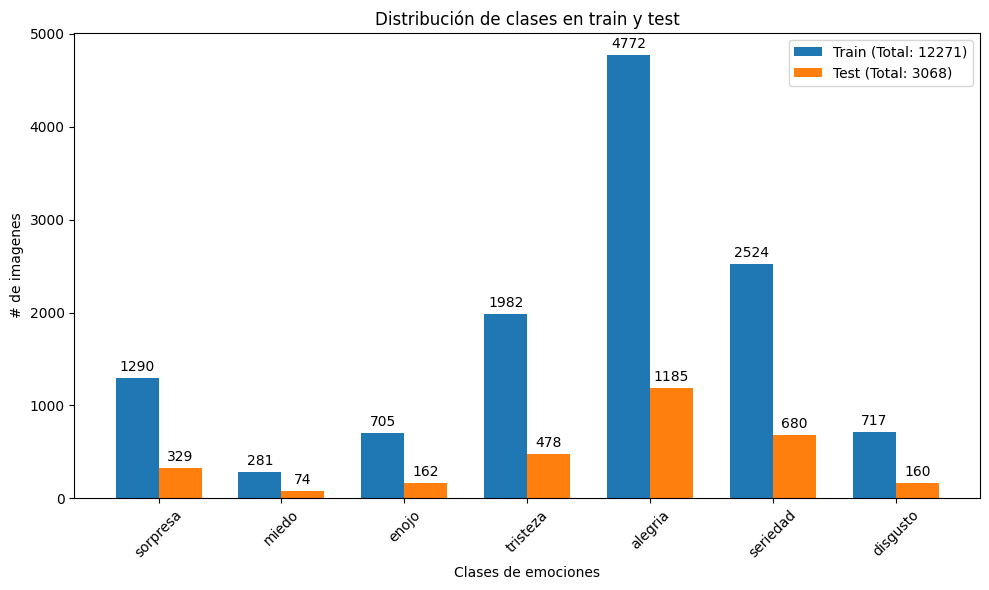

In [22]:
plot_class_distribution(train_counts, test_counts)

Se observa un desbalanceo considerable en las clases para ambos splits (train, test). Se pueden aplicar transformaciones con torch.vision para balancear aplicando rotaciones, cambios de escala, transformaciones en escalas de grises o colores, etc. Vemos que alegría es la mas desbalanceada positivamente en ambos dataset y miedo la que menos frecuencia tiene, se entiende que esto puede explicarse ya que las personas activamente propoician fotos cuando estan alegres y las evitan en el otro extremo.

In [23]:
# Para evitar data leakage obtengo mean y std de train dataset nada mas
train_mean, train_std = mean_std_dataset(dataset_path + "/train")
# mean_std_dataset(dataset_path + "/test")

Calculando media...


100%|██████████| 96/96 [00:01<00:00, 54.56it/s]


Calculando desviación estándar...


100%|██████████| 96/96 [00:02<00:00, 45.10it/s]

Media por canal: tensor([0.5752, 0.4495, 0.4012])
Desviación estándar por canal: tensor([0.2652, 0.2422, 0.2407])


In [24]:
# Cargamos train y test con los todos los canales para inspección visual inicial
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)

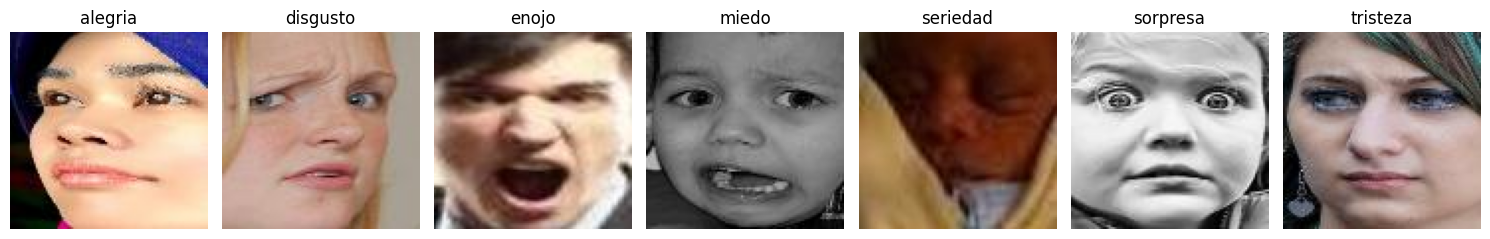

In [25]:
show_first_images_per_class(train_dataset, train_dataset.classes, train_mean, train_std)

### Transformaciones y DataLoaders

Como se dijo anteriormente. ~12k imagenes para 7 clases y con el desbalance observado parece poco para entrenar una red neuronal para esta tarea. Se realizara data augmentation con transformaciones. De esta manera atacaremos 3 frentes:
- Disminuir desbalance de clases
- Aumentar la cantidad de datos para mejorar la performance de la red neuronal en la tarea de clasificación
- Hacer al modelo a entrenar mas robustos a las transfromaciones aplicadas (por ejemplo, podra reconocer mejor emociones de caras rotadas si hacemos augmentation con transformaciones de rotación)

In [26]:
# 1- Se aplican distintas transformaciones para el dataset de train y test
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(100, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=test_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
train_targets = [label for _, label in train_dataset]

# Dividir el dataset en train y validation usando train_test_split
train_indices, val_indices = train_test_split(
    range(len(train_targets)),
    test_size=0.3,
    stratify=train_targets,
    random_state=42
)

# Crear los datasets a partir de los índices
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# 4- Se utiliza data augmentation con WeightedRandomSampler para balancear el dataset
# Obtener las etiquetas del subset de entrenamiento
targets = [train_dataset[i][1] for i in train_indices]

# Calcular pesos por clase
class_counts = Counter(targets)
train_num_samples = len(targets)
val_num_samples = len(val_subset)
class_weights = {cls: train_num_samples / count for cls, count in class_counts.items()}

# Crear los pesos por muestra
sample_weights = [class_weights[label] for label in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# Usar WeightedRandomSampler para balancear el dataset
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=DATASET_AUGMENTED_SIZE,
                                replacement=True)

# 5- Se crean los DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, num_workers=WORKERS, sampler=sampler, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {train_num_samples}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {val_num_samples}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {1: 17.109561752988046, 4: 4.860780984719864, 6: 6.192501802451334, 0: 2.571556886227545, 3: 43.598984771573605, 2: 17.421906693711968, 5: 9.511627906976743}
Tamaño de train dataset original: 8589
Tamaño de train dataset con augmentation: 30000
Tamaño de validation dataset: 3682
Tamaño de test dataset: 3068


Se divide **train** en train / validacion para poder evaluar los distintos modelos a entrenar. Test se lo separa para la evaluación final (ver que tan bien generalizan). Test no recibe ningun tipo de transformación mas allá de las necesarias para el entrenamiento (determinísticas).

Se aplica GreyScale ya que se entiende que el colo no aporta información significativa a la hora de clasificar emociones. Por otro lado, esto permite ganar en performance, ya que al pasar de 3 a 1 canal se reduce dimensionalidad y, por lo tanto, la cantidad de parámetros a entrenar y el tamaño de la red a la hora de hacer inferencia.

Se utiliza **WeightedRandomSampler** como sampler para el DataLoader de train, para poder realizar data augmentation (para tener más datos para la tarea de entrenamiento) asi como suplir el desbalance de clases. Esto se logra, como se explica en los comentarios del código, generando una cantidad muestras de manera inversamente proporcional a la presencia de cada clase. 

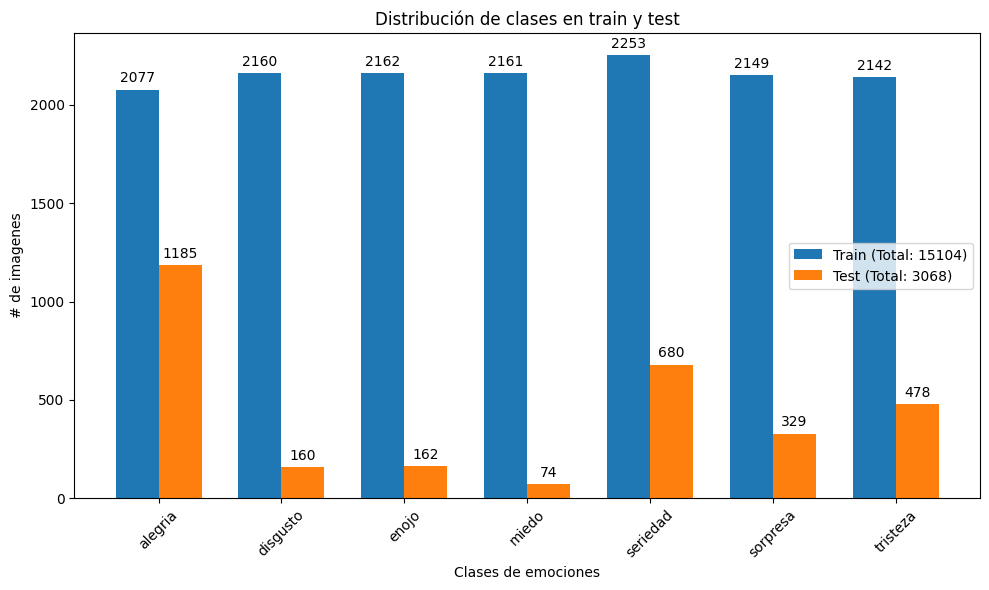

In [27]:
# Probamos el DataLoader y WeightedRandomSampler para ver balanceo de clases
sampled_labels = []
for i, (_, labels) in enumerate(train_loader):
    sampled_labels.extend(labels.numpy())
    if len(sampled_labels) >= DATASET_AUGMENTED_SIZE / 2:  # tomamos una muestra
        break

# Contamos cuántas veces aparece cada clase
balanced_train_counts = Counter(sampled_labels)

train_counts_named = map_counts_to_classnames(balanced_train_counts, train_dataset.classes)
test_counts_named = map_counts_to_classnames(Counter(test_dataset.targets), test_dataset.classes)

plot_class_distribution(train_counts_named, test_counts_named)

Podemos visualizar como se balancean las clases al graficar los datos generados por el dataloader de train.

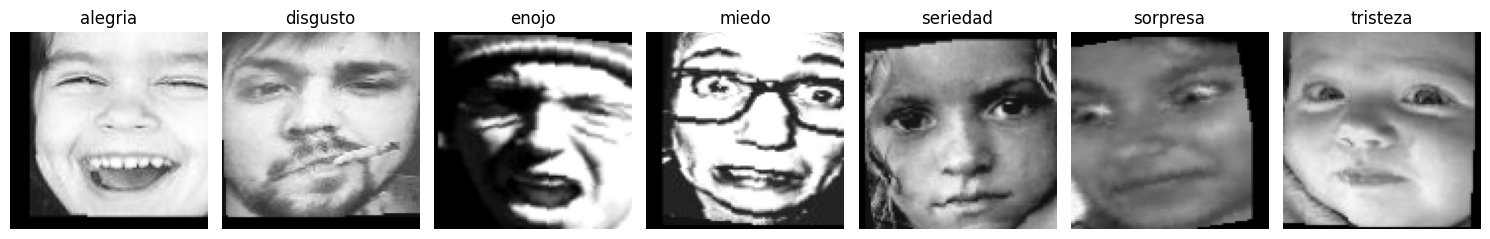

In [28]:
show_first_images_per_class_from_loader(train_loader, train_dataset.classes, [0.5], [0.5], cmap='grey')

Las imagenes se ven en escala de gris y con algunas alteraciones ya que se están graficando luego de aplicar las transformaciones sobre el dataset de train.

## 2. Construcción y entrenamiento del Modelo CNN

### Consigna

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes.

### Validación DataLoader

In [29]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(train_loader))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([128, 1, 100, 100])
Tamaño del batch del label (clase / etiqueta): torch.Size([128])


Podemos ver correctamente un torch tensor de 128 (tamaño del batch), 1 canal y 100 x 100 pixeles

### Red Convolucional CNN

#### Bloque de convolución

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling

In [30]:
def conv_block(
    c_in: int, 
    c_out: int, 
    kernel_size: int = 3, 
    padding: str = 'same', 
    stride: int = 1, 
    pooling_kernel_size:int = 2
    ) -> torch.nn.Sequential:
    """
    Bloque de convolución seguido de activación y max pooling.

    Args:
        c_in (int): Parametros de entrada.
        c_out (int): Parametros de salida. (features o cantidad de kernels)
        kernel_size (int, optional): Tamaño del kernel cuadrado. Defaults to 3.
        padding (str, optional): Padding aplicado en la convolución. Puede ser un entero o 'same'. Defaults to 'same'.
        stride (int, optional): Stride (paso) de la convolución. Defaults to 1.
        pooling_kernel_size (int, optional): Tamaño del kernel de pooling. Defaults to 2.

    Returns:
        _type_: Módulo secuencial con conv → activación → max pooling.
    """
    return torch.nn.Sequential( # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, kernel_size, padding=padding, stride=stride),
        torch.nn.BatchNorm2d(c_out),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=pooling_kernel_size)
    )

- **Conv2d**	Aprende filtros que detectan bordes, curvas, partes faciales, etc.
- **BatchNorm2d**	Estabiliza el aprendizaje y permite usar mayor tasa de aprendizaje
- **ReLU**	Introduce no linealidad (es más efectiva que tanh para este tipo de imágenes)
- **MaxPool2d**	Reduce tamaño espacial (downsampling), mantiene lo importante

#### Early Stopping

Vamos a implementar **Early Stopping** para no perder tiempo en etapa de entrenamiento. 

Este mecanismo utiliza un *patience* param, que es un contador de la cantidad de epocas en la que no obtenemos la mejora esperada en la loss function. Si el val_loss no mejora lo que indicamos y el counter es mayor o igual a patience entonces early stopping se dispara. Sino, val_loss sera mejor (menor) que (self.best_loss - self.min_delta). En donde, *min_delta* la mejora en la loss respecto de la mejor actual que estamos buscando para que tenga sentido continuar con el entrenamiento.

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Número de épocas sin mejora antes de detener.
            min_delta (float): Mínima mejora para resetear el contador.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### CNN Simple

In [32]:
class CNNSimple(torch.nn.Module):
    """
    Modelo CNN simple para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 12 * 12, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        y = self.fc(x)
        return y
    
            
cnn_simple = CNNSimple()

Red creada
arquitectura:
CNNSimple(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1

In [33]:
torchinfo.summary(cnn_simple, input_size=(12, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNNSimple                                [12, 7]                   --
├─Sequential: 1-1                        [12, 32, 50, 50]          --
│    └─Conv2d: 2-1                       [12, 32, 100, 100]        320
│    └─BatchNorm2d: 2-2                  [12, 32, 100, 100]        64
│    └─ReLU: 2-3                         [12, 32, 100, 100]        --
│    └─MaxPool2d: 2-4                    [12, 32, 50, 50]          --
├─Sequential: 1-2                        [12, 64, 25, 25]          --
│    └─Conv2d: 2-5                       [12, 64, 50, 50]          18,496
│    └─BatchNorm2d: 2-6                  [12, 64, 50, 50]          128
│    └─ReLU: 2-7                         [12, 64, 50, 50]          --
│    └─MaxPool2d: 2-8                    [12, 64, 25, 25]          --
├─Sequential: 1-3                        [12, 128, 12, 12]         --
│    └─Conv2d: 2-9                       [12, 128, 25, 25]         73,856
│    

#### Función de entrenamiento

A la función de entrenamiento se la integra con la clase de Early Stopping para cortar el proceso de entrenamiento en caso de no encontrar mejoras.

Además, se agregan los parámetros de **model_name** y **results_file** para guardar los pesos del mejor modelo y sus resultados en validacion y train para ser utilizado y analizado en pasos posteriores.

Se agrega, también, el cálculo de F1 score weighted al ser una métrica más robusta para la evaluación.

Se agrega soporte para metodo de regularizacion **weight_decay** en el optimizador a traves de un BOOL param. Esto se utilizará en la ultima variante entrenada.

In [37]:
def fit(
    model: torch.nn.Sequential, 
    train_loader: DataLoader, 
    eval_loader: DataLoader, 
    epochs: int = 5,
    weight_decay: bool = False,
    model_name: str = 'best_model.pth',
    results_file: str = 'train_data.json'
    ) -> tuple:
    """
    Entrena el modelo y evalúa su rendimiento en el conjunto de validación.

    Args:
        model (torch.nn.Sequential): Modelo PyTorch
        train_loader (DataLoader): Dataloader train
        eval_loader (DataLoader): Dataloader de validación
        epochs (int, optional): Epocas a entrenar. Defaults to 5.
    """
    # enviamos el modelo al device
    model.to(device)
    # definimos optimizer y la función de pérdida
    if not weight_decay:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    # preparamos listas para guardar las loss y la acc a lo largo de la epocas
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    epoch_v_f1 = []
    epoch_t_f1 = []
    
    # inicializamos early stopping
    early_stopping = EarlyStopping(patience=12, min_delta=0.001)
    
    # iteramos en las epocas
    for epoch in range(1, epochs+1):
        # ponemos el modelo en train
        model.train()
        # listas de loss y acc de train para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        train_loss, train_acc = [], []
        train_preds = []
        train_targets = []
        
        bar = tqdm(train_loader)
        for batch in bar:
            X, y = batch  # sacamos X e y del batch
            X, y = X.to(device), y.to(device) # lo enviamos al device
            optimizer.zero_grad() # llevamos optimizer a zero
            y_hat = model(X)  # corremos el modelo y vemos su predicción, esto es la pasada forward (ejecuta forward method del modelo)
            loss = criterion(y_hat, y)  # calculamos la pérdida
            loss.backward() # back-propagations
            optimizer.step()  # step del optimizer
            train_loss.append(loss.item()) # vamos guardando la pérdida de este batch, en la perdida de la epoca
            
            preds = torch.argmax(y_hat, axis=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(y.cpu().numpy())
            
            # calculo de la acc
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc) # vamos guardando la acc de este batch, en la acc de la epoca
                        
            # seteamos descriptores en la barra
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # luego de pasar todo el batch, guardamos la perdida y acc media del train
        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))
        # calculo f1 score
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        epoch_t_f1.append(train_f1)

        # ahora viene es test
        bar = tqdm(eval_loader)
        # listas de loss y acc de test para esta epoca
        # así despues calculamos la media
        # por que el dataset lo pasamos de a batches
        # agregamos all_preds y all_targets para guardar las predicciones y targets
        # así después podemos calcular el f1 score
        # y la matriz de confusión
        val_loss, val_acc = [], []
        all_preds = []
        all_targets = []
        
        # ponemos en eval el modelo
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                
                preds = torch.argmax(y_hat, axis=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y.cpu().numpy())
                
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
            # Calcular F1-score
            val_f1 = f1_score(all_targets, all_preds, average='weighted')
            print(f"Epoch {epoch}/{epochs} "
                f"loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} "
                f"acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f} "
                f"train_f1 {train_f1:.5f} val_f1 {val_f1:.5f}")
    
        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))
        epoch_v_f1.append(val_f1)
        
        # Guardamos el mejor modelo
        if epoch == 1 or np.mean(val_loss) < min(epoch_v_loss[:-1]): # -1 para no contar el que acabo de agregar
            print(f"Mejor modelo guardado en la época {epoch} con val_loss {np.mean(val_loss):.5f}")
            torch.save(model.state_dict(), model_name)
            print("Mejor modelo guardado.")
        
        # Mecanismo Early stopping
        early_stopping(np.mean(val_loss))
        if early_stopping.early_stop:
            print("Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.")
            break

    # Guardamos los datos de entrenamiento en JSON
    with open(results_file, 'w') as f:
        json.dump({
            'epoch_t_loss': epoch_t_loss,
            'epoch_v_loss': epoch_v_loss,
            'epoch_t_acc': epoch_t_acc,
            'epoch_v_acc': epoch_v_acc,
            'epoch_t_f1': epoch_t_f1,
            'epoch_v_f1': epoch_v_f1
        }, f, indent=4)
        print("Datos de entrenamiento guardados en train_data.json")
    

    return epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc, epoch_t_f1, epoch_v_f1
    

#### CNN (Dropout) + CONV x4

In [35]:
class CNN(torch.nn.Module):
    """
    Modelo CNN para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256)
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 6 * 6, 512), # se va a 6x6 por el maxpooling aplicado en 4 capas imagen de entrada 100x100
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(512, 256), # se aumenta la cantidad de neuronas para que el dropout no afecte tanto
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),            
            torch.nn.Linear(256, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        y = self.fc(x)
        return y
    
            
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

In [36]:
torchinfo.summary(model, input_size=(1, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 32, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 100]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 100, 100]         64
│    └─ReLU: 2-3                         [1, 32, 100, 100]         --
│    └─MaxPool2d: 2-4                    [1, 32, 50, 50]           --
├─Sequential: 1-2                        [1, 64, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 64, 50, 50]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 50, 50]           128
│    └─ReLU: 2-7                         [1, 64, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 64, 25, 25]           --
├─Sequential: 1-3                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 128, 25, 25]          73,856
│    

Para esta segunda red agregamos dropout (regularización) para ver si podemos evitar el overfitting y vamos a agregar mas complejidad agregando una capa convolucional más.

#### CNN (dropout + weight decay) + CONV x5

In [51]:
class CNNFinal(torch.nn.Module):
    """
    Modelo CNN para clasificación de imágenes.
    """
    def __init__(self, n_channels: int = 1, n_outputs: int = 7) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_outputs = n_outputs
        self._build_model()

    def _build_model(self) -> None:
        """
        Construye el modelo CNN.

        Returns:
            torch.nn.Sequential: Modelo CNN.
        """
        # Parte convolucional
        self.conv1 = conv_block(self.n_channels, 32)     # imagen en grises: canal de entrada = 1
        self.conv2 = conv_block(32, 64)
        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256)
        self.conv5 = conv_block(256, 512)
        self.dropout = torch.nn.Dropout2d(p=0.15) # Apagar píxeles aislados rompe coherencia espacial con dropout comun.Se usa dropout2d
        # Parte fully connected
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512 * 3 * 3, 512), # se va a 3x3 por el maxpooling aplicado en 5 capas imagen de entrada 100x100
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.4),
            torch.nn.Linear(512, 256), # se aumenta la cantidad de neuronas para que el dropout no afecte tanto
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.25),            
            torch.nn.Linear(256, self.n_outputs)  # 7 clases de emociones
        )
        
        print('Red creada')
        print('arquitectura:')
        print(self)

        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)
        
    def forward(self, x) -> torch.Tensor:
        """
        Pasada forward del modelo.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Tensor de salida.
        """
        #print('input shape: ', x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(self.conv3(x))
        x = self.dropout(self.conv4(x))
        x = self.dropout(self.conv5(x))
        y = self.fc(x)
        return y
    
            
model_final = CNNFinal()

Red creada
arquitectura:
CNNFinal(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [50]:
torchinfo.summary(model_final, input_size=(1, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNNFinal                                 [1, 7]                    --
├─Sequential: 1-1                        [1, 32, 50, 50]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 100]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 100, 100]         64
│    └─ReLU: 2-3                         [1, 32, 100, 100]         --
│    └─MaxPool2d: 2-4                    [1, 32, 50, 50]           --
├─Sequential: 1-2                        [1, 64, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 64, 50, 50]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 50, 50]           128
│    └─ReLU: 2-7                         [1, 64, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 64, 25, 25]           --
├─Sequential: 1-3                        [1, 128, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 128, 25, 25]          73,856
│    

#### Entrenamiento

Desacoplamos los plots de entrenamiento para poder cambiar la estetica sin reentrenar. Además, persistimos esa información en un JSON file y tambien guardamos el mejor modelo (entre todas las epocas) para utilizar luego.

In [69]:
# Entrenamos CNN Simple
fit(cnn_simple, train_loader=train_loader, eval_loader=val_loader, epochs=30, model_name='cnn_simple.pth', results_file='cnn_simple_train_data.json')   

val_loss 1.27199 val_acc 0.52994: 100%|██████████| 29/29 [00:01<00:00, 16.74it/s]


Epoch 1/30 loss 1.47864 val_loss 1.27199 acc 0.45842 val_acc 0.52994 train_f1 0.45584 val_f1 0.55732
Mejor modelo guardado en la época 1 con val_loss 1.27199
Mejor modelo guardado.


val_loss 1.49231 val_acc 0.44813: 100%|██████████| 29/29 [00:01<00:00, 19.74it/s]


Epoch 2/30 loss 1.06462 val_loss 1.49231 acc 0.60168 val_acc 0.44813 train_f1 0.60082 val_f1 0.48707


val_loss 0.94832 val_acc 0.66633: 100%|██████████| 29/29 [00:01<00:00, 19.30it/s]


Epoch 3/30 loss 0.95530 val_loss 0.94832 acc 0.64821 val_acc 0.66633 train_f1 0.64824 val_f1 0.67389
Mejor modelo guardado en la época 3 con val_loss 0.94832
Mejor modelo guardado.


val_loss 1.08510 val_acc 0.61913: 100%|██████████| 29/29 [00:01<00:00, 20.85it/s]


Epoch 4/30 loss 0.89073 val_loss 1.08510 acc 0.67084 val_acc 0.61913 train_f1 0.67121 val_f1 0.64124


val_loss 0.89167 val_acc 0.68134: 100%|██████████| 29/29 [00:01<00:00, 18.70it/s]


Epoch 5/30 loss 0.83670 val_loss 0.89167 acc 0.69222 val_acc 0.68134 train_f1 0.69260 val_f1 0.68842
Mejor modelo guardado en la época 5 con val_loss 0.89167
Mejor modelo guardado.


val_loss 0.91937 val_acc 0.67425: 100%|██████████| 29/29 [00:01<00:00, 19.23it/s]


Epoch 6/30 loss 0.79187 val_loss 0.91937 acc 0.70898 val_acc 0.67425 train_f1 0.70958 val_f1 0.68264


val_loss 0.98292 val_acc 0.65637: 100%|██████████| 29/29 [00:01<00:00, 18.91it/s]


Epoch 7/30 loss 0.72960 val_loss 0.98292 acc 0.73271 val_acc 0.65637 train_f1 0.73292 val_f1 0.67304


val_loss 1.18288 val_acc 0.59866: 100%|██████████| 29/29 [00:01<00:00, 19.53it/s]


Epoch 8/30 loss 0.70583 val_loss 1.18288 acc 0.74290 val_acc 0.59866 train_f1 0.74311 val_f1 0.63027


val_loss 0.87394 val_acc 0.69814: 100%|██████████| 29/29 [00:01<00:00, 19.44it/s]


Epoch 9/30 loss 0.68101 val_loss 0.87394 acc 0.75062 val_acc 0.69814 train_f1 0.75080 val_f1 0.70405
Mejor modelo guardado en la época 9 con val_loss 0.87394
Mejor modelo guardado.


val_loss 0.90554 val_acc 0.67570: 100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


Epoch 10/30 loss 0.65217 val_loss 0.90554 acc 0.76148 val_acc 0.67570 train_f1 0.76173 val_f1 0.69351


val_loss 0.85639 val_acc 0.70111: 100%|██████████| 29/29 [00:01<00:00, 19.05it/s]


Epoch 11/30 loss 0.62266 val_loss 0.85639 acc 0.77154 val_acc 0.70111 train_f1 0.77174 val_f1 0.70954
Mejor modelo guardado en la época 11 con val_loss 0.85639
Mejor modelo guardado.


val_loss 0.97872 val_acc 0.66571: 100%|██████████| 29/29 [00:01<00:00, 20.04it/s]


Epoch 12/30 loss 0.59643 val_loss 0.97872 acc 0.78293 val_acc 0.66571 train_f1 0.78312 val_f1 0.67846


val_loss 0.84242 val_acc 0.71006: 100%|██████████| 29/29 [00:01<00:00, 19.57it/s]


Epoch 13/30 loss 0.57693 val_loss 0.84242 acc 0.78970 val_acc 0.71006 train_f1 0.78982 val_f1 0.70974
Mejor modelo guardado en la época 13 con val_loss 0.84242
Mejor modelo guardado.


val_loss 0.80569 val_acc 0.70747: 100%|██████████| 29/29 [00:01<00:00, 18.85it/s]


Epoch 14/30 loss 0.55004 val_loss 0.80569 acc 0.79801 val_acc 0.70747 train_f1 0.79819 val_f1 0.71139
Mejor modelo guardado en la época 14 con val_loss 0.80569
Mejor modelo guardado.


val_loss 0.90426 val_acc 0.68739: 100%|██████████| 29/29 [00:01<00:00, 17.07it/s]


Epoch 15/30 loss 0.52900 val_loss 0.90426 acc 0.80732 val_acc 0.68739 train_f1 0.80745 val_f1 0.70038


val_loss 0.93000 val_acc 0.69787: 100%|██████████| 29/29 [00:01<00:00, 17.17it/s]


Epoch 16/30 loss 0.51742 val_loss 0.93000 acc 0.81110 val_acc 0.69787 train_f1 0.81111 val_f1 0.70670


val_loss 0.83003 val_acc 0.73198: 100%|██████████| 29/29 [00:01<00:00, 17.20it/s]


Epoch 17/30 loss 0.49703 val_loss 0.83003 acc 0.82056 val_acc 0.73198 train_f1 0.82062 val_f1 0.73553


val_loss 0.84292 val_acc 0.71565: 100%|██████████| 29/29 [00:01<00:00, 15.98it/s]


Epoch 18/30 loss 0.48268 val_loss 0.84292 acc 0.82281 val_acc 0.71565 train_f1 0.82287 val_f1 0.72436


val_loss 0.86169 val_acc 0.70991: 100%|██████████| 29/29 [00:01<00:00, 15.49it/s]


Epoch 19/30 loss 0.47191 val_loss 0.86169 acc 0.82772 val_acc 0.70991 train_f1 0.82785 val_f1 0.71991


val_loss 0.80903 val_acc 0.73834: 100%|██████████| 29/29 [00:02<00:00, 12.90it/s]


Epoch 20/30 loss 0.45782 val_loss 0.80903 acc 0.83362 val_acc 0.73834 train_f1 0.83364 val_f1 0.74167


val_loss 0.85147 val_acc 0.72071: 100%|██████████| 29/29 [00:01<00:00, 17.97it/s]


Epoch 21/30 loss 0.43513 val_loss 0.85147 acc 0.84247 val_acc 0.72071 train_f1 0.84258 val_f1 0.72535


val_loss 0.90762 val_acc 0.71638: 100%|██████████| 29/29 [00:01<00:00, 16.86it/s]


Epoch 22/30 loss 0.43697 val_loss 0.90762 acc 0.84115 val_acc 0.71638 train_f1 0.84117 val_f1 0.72133


val_loss 0.87010 val_acc 0.72351: 100%|██████████| 29/29 [00:02<00:00, 14.46it/s]


Epoch 23/30 loss 0.42070 val_loss 0.87010 acc 0.84652 val_acc 0.72351 train_f1 0.84658 val_f1 0.73142


val_loss 0.84744 val_acc 0.73043: 100%|██████████| 29/29 [00:02<00:00, 13.92it/s]


Epoch 24/30 loss 0.40409 val_loss 0.84744 acc 0.85469 val_acc 0.73043 train_f1 0.85480 val_f1 0.73369


val_loss 0.92006 val_acc 0.71253: 100%|██████████| 29/29 [00:01<00:00, 16.16it/s]


Epoch 25/30 loss 0.39639 val_loss 0.92006 acc 0.85575 val_acc 0.71253 train_f1 0.85578 val_f1 0.72443


val_loss 0.85864 val_acc 0.73260: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]

Epoch 26/30 loss 0.39075 val_loss 0.85864 acc 0.85979 val_acc 0.73260 train_f1 0.85978 val_f1 0.73739
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(1.4786370828023652),
  np.float64(1.0646230837573176),
  np.float64(0.9553030380202682),
  np.float64(0.8907332283151729),
  np.float64(0.8367010519632598),
  np.float64(0.7918686868284669),
  np.float64(0.7296048657363637),
  np.float64(0.7058324444172023),
  np.float64(0.6810093352861721),
  np.float64(0.652170044077022),
  np.float64(0.6226588761257699),
  np.float64(0.5964260137142123),
  np.float64(0.5769279232567839),
  np.float64(0.5500374260308493),
  np.float64(0.5289952630734505),
  np.float64(0.5174237949311581),
  np.float64(0.497033974856062),
  np.float64(0.48268149758848694),
  np.float64(0.4719103913935249),
  np.float64(0.45782427211551713),
  np.float64(0.4351277341470694),
  np.float64(0.43696831810809766),
  np.float64(0.42069584855338193),
  np.float64(0.4040914977831609),
  np.float64(0.39639486040910493),
  np.float64(0.39074798698163093)],
 [np.float64(1.2719942495740693),
  np.float64(1.4923056528486054),
  np.float64(0.9483173448463966),
  np.floa

Se observa a partir de la epoca ~10 aproximadamente que, mientras que loss en train baja de manera suave, loss en validación empieza a subir. Lo mismo sucede con Accuracy, donde a partir de esa misma epoca val accuracy pierde su pendiente positiva. 

Debido a estos resultados es que se procede a implementar un modelo con mas complejidad y, además, se implementara regularización y early stoppping para que la busqueda de epocas no sea un proceso manual.

No obstante a los resultados mencionados anteriormente, los resultados finales de este modelo fueron:

**Epoch 30/30:**  
| Metric       | Train       | Validation  |
|--------------|-------------|-------------|
| Accuracy     | **0.81747** | **0.70884** |
| Loss         | **0.51458** | **0.85754** |

Resumiendo, se implementará:
- Dropout
- Early Stopping
- Mayor complejidad de modelo
- Mayor data augmentation
- Se agregará F1 weighted score para mayor robustez en evaluación
- Se agregará tiempo de entrenamiento como métrica de evaluación final del modelo




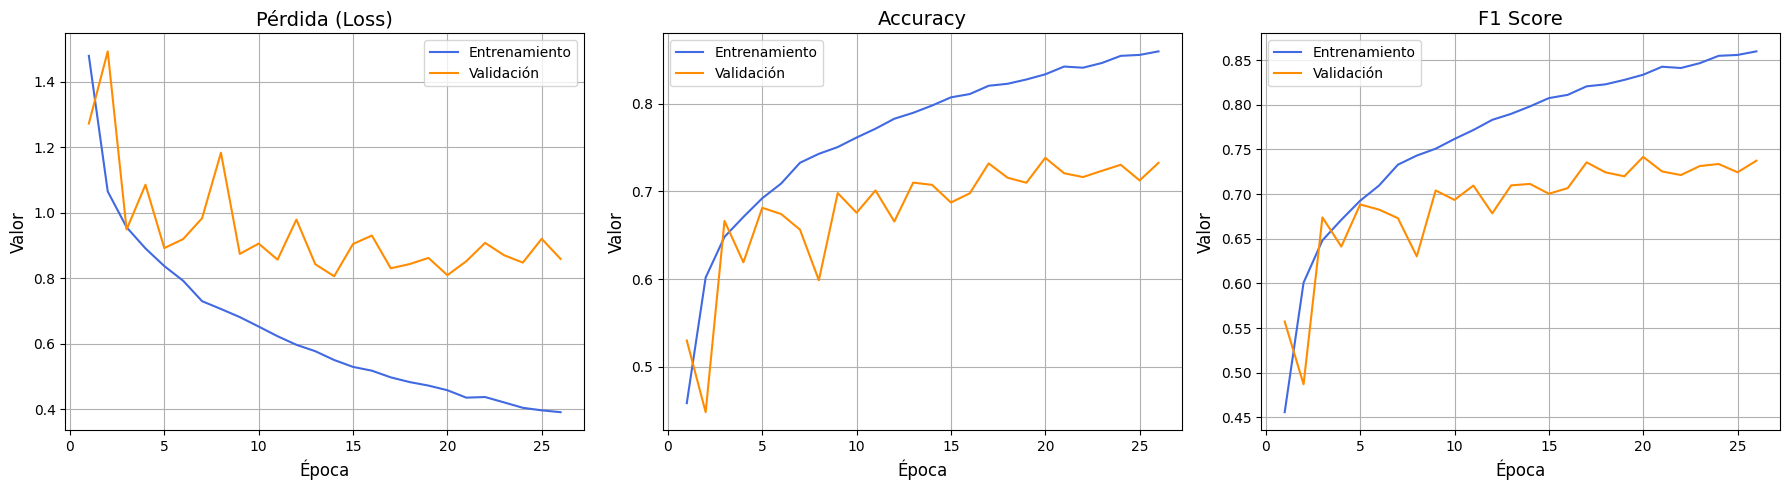

In [70]:
plot_train_results_from_json(json_file='cnn_simple_train_data.json')

In [ ]:
fit(model=model, train_loader=train_loader, eval_loader=val_loader, epochs=10, model_name='cnn.pth', results_file='cnn_train_data.json')

val_loss 0.83343 val_acc 0.69661: 100%|██████████| 29/29 [00:01<00:00, 19.09it/s]


Epoch 1/10 loss 0.38635 val_loss 0.83343 acc 0.86204 val_acc 0.69661 train_f1 0.86220 val_f1 0.70055
Mejor modelo guardado en la época 1 con val_loss 0.83343
Mejor modelo guardado.


val_loss 0.78827 val_acc 0.71994: 100%|██████████| 29/29 [00:01<00:00, 15.02it/s]


Epoch 2/10 loss 0.36124 val_loss 0.78827 acc 0.87084 val_acc 0.71994 train_f1 0.87102 val_f1 0.72748
Mejor modelo guardado en la época 2 con val_loss 0.78827
Mejor modelo guardado.


val_loss 0.75448 val_acc 0.74174: 100%|██████████| 29/29 [00:01<00:00, 16.49it/s]


Epoch 3/10 loss 0.33631 val_loss 0.75448 acc 0.88181 val_acc 0.74174 train_f1 0.88202 val_f1 0.73961
Mejor modelo guardado en la época 3 con val_loss 0.75448
Mejor modelo guardado.


val_loss 0.78270 val_acc 0.71288: 100%|██████████| 29/29 [00:01<00:00, 16.13it/s]


Epoch 4/10 loss 0.32608 val_loss 0.78270 acc 0.88417 val_acc 0.71288 train_f1 0.88454 val_f1 0.72086


val_loss 0.73060 val_acc 0.75507: 100%|██████████| 29/29 [00:01<00:00, 16.56it/s]


Epoch 5/10 loss 0.30961 val_loss 0.73060 acc 0.88985 val_acc 0.75507 train_f1 0.89008 val_f1 0.75615
Mejor modelo guardado en la época 5 con val_loss 0.73060
Mejor modelo guardado.


val_loss 0.75874 val_acc 0.73797: 100%|██████████| 29/29 [00:01<00:00, 15.34it/s]


Epoch 6/10 loss 0.29416 val_loss 0.75874 acc 0.89561 val_acc 0.73797 train_f1 0.89594 val_f1 0.74608


val_loss 0.75644 val_acc 0.74346: 100%|██████████| 29/29 [00:01<00:00, 15.06it/s]


Epoch 7/10 loss 0.28027 val_loss 0.75644 acc 0.90180 val_acc 0.74346 train_f1 0.90211 val_f1 0.74343


val_loss 0.73704 val_acc 0.74991: 100%|██████████| 29/29 [00:01<00:00, 16.72it/s]


Epoch 8/10 loss 0.26514 val_loss 0.73704 acc 0.90806 val_acc 0.74991 train_f1 0.90828 val_f1 0.75521


val_loss 0.75931 val_acc 0.75049: 100%|██████████| 29/29 [00:01<00:00, 16.65it/s]


Epoch 9/10 loss 0.25645 val_loss 0.75931 acc 0.91015 val_acc 0.75049 train_f1 0.91050 val_f1 0.75271


val_loss 0.71349 val_acc 0.76564: 100%|██████████| 29/29 [00:01<00:00, 16.38it/s]


Epoch 10/10 loss 0.25354 val_loss 0.71349 acc 0.91342 val_acc 0.76564 train_f1 0.91367 val_f1 0.77059
Mejor modelo guardado en la época 10 con val_loss 0.71349
Mejor modelo guardado.
Datos de entrenamiento guardados en train_data.json


([np.float64(0.3863508726858422),
  np.float64(0.3612438646881172),
  np.float64(0.3363089682653432),
  np.float64(0.32608016734690315),
  np.float64(0.30961106073520983),
  np.float64(0.29415835813640634),
  np.float64(0.2802690588833426),
  np.float64(0.26513538004644693),
  np.float64(0.2564482400979837),
  np.float64(0.2535424243725474)],
 [np.float64(0.833428695284087),
  np.float64(0.7882728391680224),
  np.float64(0.754476600679858),
  np.float64(0.7827014861435726),
  np.float64(0.7306043238475405),
  np.float64(0.7587395906448364),
  np.float64(0.7564351558685303),
  np.float64(0.7370372394035603),
  np.float64(0.7593144815543602),
  np.float64(0.7134922187903832)],
 [np.float64(0.8620364450127876),
  np.float64(0.8708399936061382),
  np.float64(0.881809462915601),
  np.float64(0.884171195652174),
  np.float64(0.8898457480818415),
  np.float64(0.8956122122762148),
  np.float64(0.9018022698209719),
  np.float64(0.9080602621483376),
  np.float64(0.9101502557544756),
  np.float64

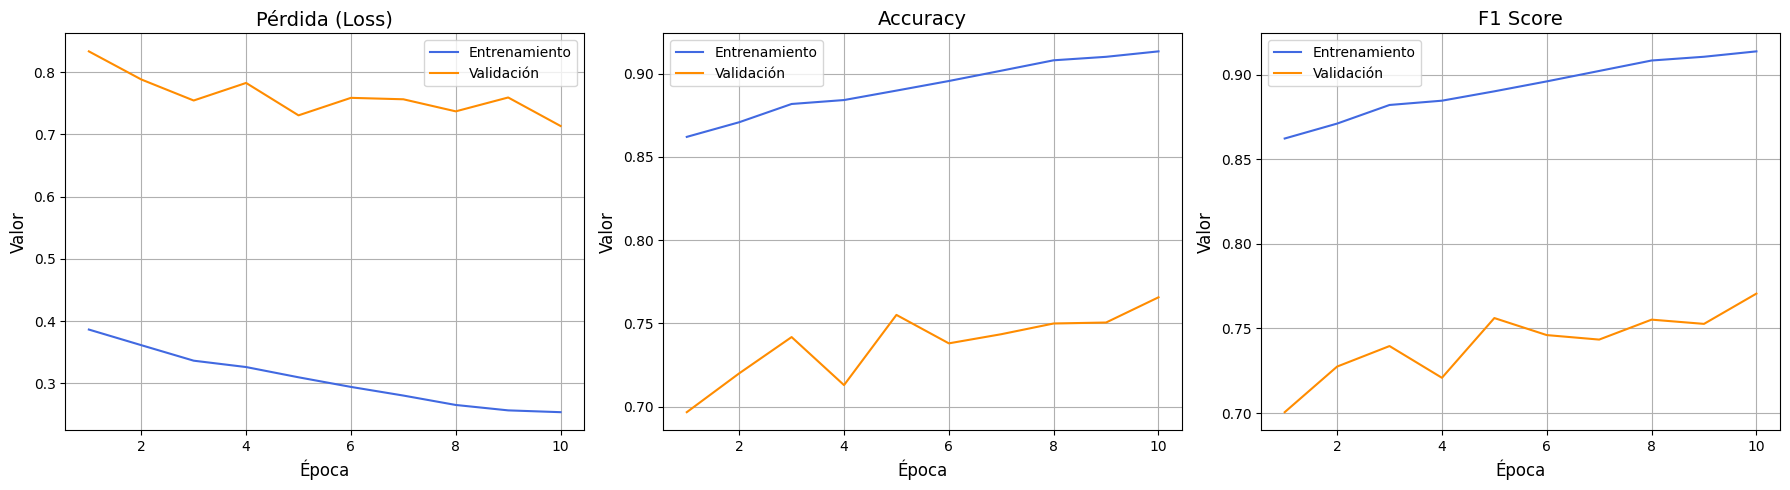

In [73]:
plot_train_results_from_json(json_file='cnn_train_data.json')

In [ ]:
fit(model=model_final, train_loader=train_loader, eval_loader=val_loader, epochs=80, weight_decay=True, model_name='cnn_final.pth', results_file='cnn_train_data_final.json')

val_loss 1.79688 val_acc 0.29881: 100%|██████████| 29/29 [00:03<00:00,  7.83it/s]


Epoch 1/80 loss 1.84429 val_loss 1.79688 acc 0.22848 val_acc 0.29881 train_f1 0.22313 val_f1 0.28006
Mejor modelo guardado en la época 1 con val_loss 1.79688
Mejor modelo guardado.


val_loss 1.35687 val_acc 0.51223: 100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


Epoch 2/80 loss 1.62503 val_loss 1.35687 acc 0.35778 val_acc 0.51223 train_f1 0.34502 val_f1 0.49274
Mejor modelo guardado en la época 2 con val_loss 1.35687
Mejor modelo guardado.


loss 1.43435 acc 0.45105:  21%|██        | 49/235 [00:11<00:34,  5.34it/s]

In [ ]:
plot_train_results_from_json(json_file='cnn_train_data_final.json')

## 3. Evaluación del Modelo

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de test.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.

 ## 4. Prueba con Imágenes Nuevas

Subir al menos 3 imágenes personales (con el rostro de ustedes o de otras personas), que no formen parte del dataset de entrenamiento ni de testeo.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo preprocesamiento que se usó para el dataset.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original (preprocesada)

  - La clase inferida por el modelo

- Redactar conclusiones y comentarios finales